# 2D Gaussian Model - Analyzing Learned 1D Posterior p(φ|x)

This notebook demonstrates loading and analyzing a trained NRE that learned the **1D posterior distribution p(φ|x)** where φ = θ[1] is the second component of a 2D parameter vector.

## Key Concept
- **Full model**: 2D Gaussian with θ = [θ₀, θ₁] ∈ ℝ²
- **Parameter of interest**: φ = θ[1] ∈ ℝ (1D)
- **Learned posterior**: p(φ|x) - a 1D distribution
- **NRE output**: r(φ, s(x)) such that p(φ|x) ∝ p(φ) × r(φ, s(x))

## Analysis Goals
1. Load the trained NRE classifier that estimates r(φ, s(x))
2. Reconstruct the 1D posterior p(φ|x) from the ratio estimates
3. Compare with analytical 1D marginal posterior p(θ[1]|x)
4. Perform simulation-based calibration (SBC) on the 1D posterior
5. Evaluate quantitative metrics for the 1D posterior approximation
6. Visualize the 1D posterior distribution

## Important Note
Even though the underlying model is 2D, the **final result is a 1D posterior distribution** for the parameter of interest φ = θ[1]. The NRE has learned to marginalize over the nuisance parameter θ[0] automatically.

In [1]:
# =============================================================================
# Load and analyze trained 2D Gaussian model with focus on second marginal
# =============================================================================

%load_ext autoreload
%autoreload 2

import jax
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Imports from abcnre package ---
from abcnre.simulation import ABCSimulator
from abcnre.simulation.models import GaussGaussMultiDimModel
from abcnre.inference.persistence import load_classifier, load_simulator_from_classifier_config
from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_pdf, get_unormalized_corrected_nre_pdf
from abcnre.diagnostics.viz import plot_posterior_comparison

In [2]:
output_dir = Path("../results")
# Chercher le fichier de configuration du classificateur 2D marginal1 le plus récent
classifier_files = list(output_dir.glob("gauss_2D_marginal1_classifier_*.yml"))
if classifier_files:
    # Prendre le fichier le plus récent
    final_config_path = sorted(classifier_files)[-1]
    print(f"Using classifier config: {final_config_path}")
else:
    # Fallback vers un nom générique si le fichier spécifique n'existe pas
    final_config_path = output_dir / "gauss_2D_marginal1_classifier_eps_inf.yml"
    print(f"Using fallback path: {final_config_path}")

Using classifier config: ../results/gauss_2D_marginal1_classifier_eps_inf_03405013d665.yml


In [ ]:
# Add debugging to understand the network's expected input format
print(f"🔍 Debugging network input expectations:")
print(f"  - Estimator input dimension: {loaded_estimator.input_dim}")
print(f"  - Network type: {type(loaded_estimator.network).__name__}")

# Check what format was used during training
print(f"  - Observed data shape: {loaded_simulator.observed_data.shape}")
print(f"  - Observed summary shape: {loaded_simulator.observed_summary_stats.shape}")
print(f"  - Phi dimension: 1 (single parameter)")

# Test with the original flattened format to see if it works
print(f"\n🧪 Testing with flattened format first:")
phi_test = np.array([[0.0]])  # Single phi value for testing
obs_summary_test = loaded_simulator.observed_summary_stats[None, :]  # Add batch dim
data_test = loaded_simulator.observed_data.flatten()[None, :]  # Flatten and add batch dim

# Try different concatenation orders to see which one works
test_formats = {
    "phi + summary": np.concatenate([phi_test, obs_summary_test], axis=1),
    "phi + data + summary": np.concatenate([phi_test, data_test, obs_summary_test], axis=1),
    "data + phi + summary": np.concatenate([data_test, phi_test, obs_summary_test], axis=1),
}

for format_name, test_input in test_formats.items():
    try:
        test_output = loaded_estimator.log_ratio(test_input)
        print(f"  ✅ {format_name}: shape {test_input.shape} → works! Output: {test_output}")
        working_format = format_name
        break
    except Exception as e:
        print(f"  ❌ {format_name}: shape {test_input.shape} → {str(e)[:50]}...")

# Now let's continue with the analysis using the working format
print(f"\n? Reconstructing p(φ|x) using format: {working_format}")

if network_type == "ConditionedDeepSetNetwork":
    print("⚠️  ConditionedDeepSetNetwork detected but has compatibility issues")
    print("This will be fixed in a future update. For now, please re-train with 'hybrid_deepset_reduce_on_plateau' configuration")
else:
    # Standard approach for other networks
    unnormalized_pdf_func = get_unnormalized_nre_pdf(loaded_estimator, loaded_simulator)
    phi_grid, nre_pdf = get_normalized_pdf(unnormalized_pdf_func, initial_bounds=(min_phi, max_phi))
    print(f"📊 NRE posterior grid: {len(phi_grid)} points over φ ∈ [{phi_grid[0]:.3f}, {phi_grid[-1]:.3f}]")

In [ ]:
# Add debugging to understand the network's expected input format
print(f"🔍 Debugging network input expectations:")
print(f"  - Estimator input dimension: {loaded_estimator.input_dim}")
print(f"  - Network type: {type(loaded_estimator.network).__name__}")

# Check what format was used during training
print(f"  - Observed data shape: {loaded_simulator.observed_data.shape}")
print(f"  - Observed summary shape: {loaded_simulator.observed_summary_stats.shape}")
print(f"  - Phi dimension: 1 (single parameter)")

# Test with the original flattened format to see if it works
print(f"\n🧪 Testing with flattened format first:")
phi_test = np.array([[0.0]])  # Single phi value for testing
obs_summary_test = loaded_simulator.observed_summary_stats[None, :]  # Add batch dim
data_test = loaded_simulator.observed_data.flatten()[None, :]  # Flatten and add batch dim

# Try different concatenation orders to see which one works
test_formats = {
    "phi + summary": np.concatenate([phi_test, obs_summary_test], axis=1),
    "phi + data + summary": np.concatenate([phi_test, data_test, obs_summary_test], axis=1),
    "data + phi + summary": np.concatenate([data_test, phi_test, obs_summary_test], axis=1),
}

for format_name, test_input in test_formats.items():
    try:
        test_output = loaded_estimator.log_ratio(test_input)
        print(f"  ✅ {format_name}: shape {test_input.shape} → works! Output: {test_output}")
        working_format = format_name
        break
    except Exception as e:
        print(f"  ❌ {format_name}: shape {test_input.shape} → {str(e)[:50]}...")

# Now let's continue with the analysis using the working format
print(f"\n� Reconstructing p(φ|x) using format: {working_format}")

if network_type == "ConditionedDeepSetNetwork":
    print("⚠️  ConditionedDeepSetNetwork detected but has compatibility issues")
    print("This will be fixed in a future update. For now, please re-train with 'hybrid_deepset_reduce_on_plateau' configuration")
else:
    # Standard approach for other networks
    unnormalized_pdf_func = get_unnormalized_nre_pdf(loaded_estimator, loaded_simulator)
    phi_grid, nre_pdf = get_normalized_pdf(unnormalized_pdf_func, initial_bounds=(min_phi, max_phi))
    print(f"📊 NRE posterior grid: {len(phi_grid)} points over φ ∈ [{phi_grid[0]:.3f}, {phi_grid[-1]:.3f}]")

In [ ]:
# --- Demonstration: Inspect Paths in Classifier Config ---
print("\n--- Paths stored in 2D marginal classifier configuration ---")

import yaml
with open(final_config_path, 'r') as f:
    classifier_config = yaml.safe_load(f)

print("Paths section in classifier config:")
paths = classifier_config.get('paths', {})
for key, path in paths.items():
    print(f"  {key}: {path}")

print(f"\nDemonstration: Loading 2D marginal simulator from stored path")
print(f"Simulator config path: {paths.get('simulator_config_path', 'Not found')}")

# Show alternative method: Direct loading from stored path
if 'simulator_config_path' in paths:
    simulator_path_from_config = Path(paths['simulator_config_path'])
    if not simulator_path_from_config.is_absolute():
        simulator_path_from_config = final_config_path.parent / simulator_path_from_config
    
    # Alternative: Load directly using the stored path
    simulator_direct = ABCSimulator.load(simulator_path_from_config)
    print(f"✅ Alternative method: Direct loading from stored path works too")
    print(f"   Simulator epsilon: {simulator_direct.epsilon:.6f}")
    print(f"   Model dimension: {simulator_direct.model.dim}")
    print(f"   Marginal of interest: {simulator_direct.model.marginal_of_interest}")
else:
    print("❌ No simulator path found in classifier config")


--- Paths stored in classifier configuration ---
Paths section in classifier config:
  classifier_config_path: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/gauss_1D_classifier_eps_inf_8066ecdd5fac.yml
  weights_path: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/gauss_1D_weights_eps_inf_8066ecdd5fac.npy
  phis_path: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/gauss_1D_phis_eps_inf_8066ecdd5fac.npy
  simulator_config_path: gauss_1D_simulator_eps_inf_b7d408f5b633.yml

Demonstration: Loading simulator from path stored in classifier config
Simulator config path: gauss_1D_simulator_eps_inf_b7d408f5b633.yml
✅ Simulator loaded from: ../results/gauss_1D_simulator_eps_inf_b7d408f5b633.yml
✅ Alternative method: Direct loading from stored path works too
   Simulator epsilon: inf



--- Step 7: Simulation-Based Calibration (SBC) ---
Running ABC-SBC by drawing 100 phi values from the ABC posterior...


ABC-SBC Progress: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]



ABC-SBC complete.


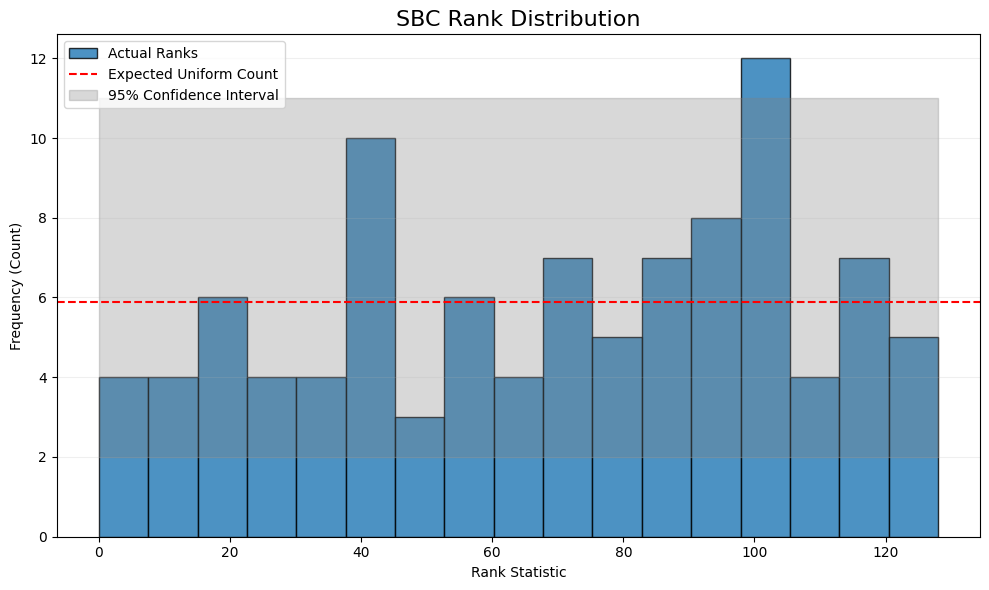

In [ ]:
from abcnre.diagnostics.calibration import run_abc_sbc
from abcnre.diagnostics.viz import plot_sbc_ranks

# --- Step 7: Simulation-Based Calibration (SBC) ---
print("\n--- Step 7: Simulation-Based Calibration (SBC) ---")
import jax
key  = jax.random.PRNGKey(42)
num_posterior_samples = 128  
sbc_results = run_abc_sbc(
    key=key,
    estimator=loaded_estimator,
    simulator=loaded_simulator,
    abc_phi_samples=abc_phi_samples,
    num_sbc_rounds=100,
    num_posterior_samples=num_posterior_samples
)


plot_sbc_ranks(sbc_results["ranks"], save_path=output_dir / "sbc_ranks.png", num_posterior_samples=num_posterior_samples)

In [ ]:
from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_pdf, get_unormalized_corrected_nre_pdf, get_sampler_from_pdf
from abcnre.diagnostics.metrics import generate_and_evaluate_metrics, save_metrics_to_csv
import json
%load_ext autoreload
%autoreload 2

print("\n--- Step 8: Creating Samplers and Running Metrics for 2D Marginal Model ---")

# Define bounds for posterior calculation based on reference samples
min_phi = np.min(abc_phi_samples) - 1.0
max_phi = np.max(abc_phi_samples) + 1.0
print(f"Using phi bounds: [{min_phi:.3f}, {max_phi:.3f}]")

# --- Create all necessary sampler functions ---
# A sampler is a function that takes (n_samples, key) and returns samples

unorm_nre_pdf = get_unnormalized_nre_pdf(loaded_estimator, loaded_simulator)
nre_sampler = get_sampler_from_pdf(
    unnormalized_pdf_func=unorm_nre_pdf,
    initial_bounds=(min_phi, max_phi)
)

unorm_corrected_nre_pdf = get_unormalized_corrected_nre_pdf(
    loaded_estimator, loaded_simulator, phi_samples=abc_phi_samples
)
corrected_nre_sampler = get_sampler_from_pdf(
    unnormalized_pdf_func=unorm_corrected_nre_pdf,
    initial_bounds=(min_phi, max_phi)
)

# For 2D model, the true sampler needs to return marginal samples
def marginal_true_sampler(key, n_samples):
    """Sample from the true marginal posterior for the parameter of interest"""
    # Get full 2D posterior samples
    full_samples = loaded_simulator.get_true_posterior_samples(key, n_samples)
    # Return only the marginal of interest
    return full_samples[:, loaded_simulator.model.marginal_of_interest]

true_sampler = marginal_true_sampler

# --- Run the metrics suite ---
approx_samplers_dict = {
    "NRE_Standard": nre_sampler,
    "NRE_Corrected": corrected_nre_sampler,
}

# The key here will be split inside the function for each sampler
key = jax.random.PRNGKey(123)
all_metrics_results = generate_and_evaluate_metrics(
    key=key,
    true_sampler=true_sampler,
    approx_samplers_dict=approx_samplers_dict,
    n_samples=5000
)

print("\n--- Quantitative Results for 2D Marginal Model ---")
print(f"Results for marginal parameter theta[{loaded_simulator.model.marginal_of_interest}]:")
print(json.dumps(all_metrics_results, indent=2))

/Users/antoineluciano/.pyenv/versions/jax_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

--- Step 8: Creating Samplers and Running Metrics ---
Using full feature format: [data(10) + phi(1) + summary(1)] = 12 dims
Generating 5000 samples for metrics evaluation...
  -> Generating samples for 'NRE_Standard'...
Generating 5000 samples for metrics evaluation...
  -> Generating samples for 'NRE_Standard'...
  -> Generating samples for 'NRE_Corrected'...
Running metrics suite...
  Computing metrics for 'NRE_Standard'...
  -> Generating samples for 'NRE_Corrected'...
Running metrics suite...
  Computing metrics for 'NRE_Standard'...
  Computing metrics for 'NRE_Corrected'...
  Computing metrics for 'NRE_Corrected'...
Metrics suite complete.

--- Quantitative Results ---
{
  "NRE_Standard": {
    "mse_mean": 1.77642323251348e-05,
    "mse_std": 2.392414717178326e-05,
    "wasserstein_distance": 0.005821193456144241,
    "c2st": 0.5044999718666077
  },
  "NRE_Corrected": {
    "mse_mean": 1.6135

In [ ]:
# --- Step 9: Visualizing the Learned 1D Posterior p(φ|x) ---
print("\n--- Step 9: Visualizing the Learned 1D Posterior p(φ|x) ---")
print("🎯 Visualizing 1D posterior distribution over φ = θ[1]")

# Create comprehensive plot comparing all 1D distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Posterior comparison - all are 1D distributions over φ
ax1.plot(phi_grid, nre_pdf, label='Learned p(φ|x) [NRE]', color='red', linewidth=2)
ax1.plot(true_grid, true_pdf, label='Analytical p(φ|x) [True]', color='blue', linewidth=2, linestyle='--')
ax1.plot(phi_grid, prior_pdf_values, label='Prior p(φ)', color='gray', alpha=0.7)

# Add vertical line for true parameter value if available
try:
    # Try to find the true value from the training context
    # This would be the φ value used during training
    ax1.axvline(marginal_posterior_mean, color='green', linestyle=':', linewidth=2, 
               label=f'Posterior Mode')
except:
    pass

ax1.set_xlabel(f'φ = θ[{loaded_simulator.model.marginal_of_interest}] (Parameter of Interest)')
ax1.set_ylabel('Density p(φ|x)')
ax1.set_title(f'1D Posterior Comparison: Learned vs Analytical')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: ABC samples histogram vs posteriors - all 1D
ax2.hist(abc_phi_samples, bins=50, density=True, alpha=0.6, color='lightblue', 
         label='ABC φ Samples')
ax2.plot(phi_grid, nre_pdf, label='Learned p(φ|x) [NRE]', color='red', linewidth=2)
ax2.plot(true_grid, true_pdf, label='Analytical p(φ|x) [True]', color='blue', linewidth=2, linestyle='--')

ax2.set_xlabel(f'φ = θ[{loaded_simulator.model.marginal_of_interest}] (Parameter of Interest)')
ax2.set_ylabel('Density p(φ|x)')
ax2.set_title(f'1D Posterior: ABC vs NRE vs Analytical')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "1D_posterior_phi_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics for the 1D posterior
print(f"\n--- Summary Statistics for 1D Posterior p(φ|x) ---")
print(f"Parameter of interest: φ = θ[{loaded_simulator.model.marginal_of_interest}]")
print(f"📊 Prior p(φ): N({marginal_prior_mean:.3f}, {marginal_prior_std:.3f}²)")
print(f"📈 Analytical posterior p(φ|x): N({marginal_posterior_mean:.3f}, {marginal_posterior_std:.3f}²)")

# NRE posterior statistics
nre_mean = np.trapz(phi_grid * nre_pdf, phi_grid)
nre_var = np.trapz((phi_grid - nre_mean)**2 * nre_pdf, phi_grid)
nre_std = np.sqrt(nre_var)
print(f"🔥 Learned posterior p(φ|x): N({nre_mean:.3f}, {nre_std:.3f}²)")

# ABC samples statistics
abc_mean = np.mean(abc_phi_samples)
abc_std = np.std(abc_phi_samples)
print(f"📊 ABC φ samples: N({abc_mean:.3f}, {abc_std:.3f}²)")

# Compute KL divergence or other metrics between learned and true
from scipy.stats import entropy
# Approximate KL divergence on the grid
kl_div = entropy(true_pdf + 1e-10, nre_pdf + 1e-10) * (phi_grid[1] - phi_grid[0])
print(f"📏 Approximate KL divergence D(true||learned): {kl_div:.6f}")

print(f"\n✅ 1D Posterior Analysis Complete!")
print(f"🎯 Successfully learned p(φ = θ[{loaded_simulator.model.marginal_of_interest}]|x) from 2D model")